# load data

In [19]:
# Importing all necessary packages
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

# Ensure necessary components are downloaded
# nltk.download('punkt')
# nltk.download('stopwords')

In [4]:
data = pd.read_json("20231012_235128_issue_sharings.json")
data = pd.json_normalize(data['Sources'])
chatgpt_sharing_data = pd.json_normalize(data['ChatgptSharing'].explode())
first_column_data = chatgpt_sharing_data.iloc[:, 0]
first_column_df = pd.DataFrame(first_column_data)
expanded_chatgpt_sharing = data['ChatgptSharing'].apply(pd.Series).stack().reset_index(drop=True)
all_attributes_chatgpt_sharing = pd.json_normalize(expanded_chatgpt_sharing)
conversations_data = pd.json_normalize(all_attributes_chatgpt_sharing['Conversations'].explode())
conversations_data

,Prompt,Answer,ListOfCode
0,Raspberry Piをアクセスポイント化させて、Wi-Fi通信をスマホとさせました。Ra...,ChatGPTRaspberry Piをアクセスポイントとして設定し、スマホとのWi-Fi通...,[]
1,Raspberry Piには地図タイルが入っており、これをWi−Fi通信でスマホに配信します...,ChatGPT地図タイルを配信するためのRaspberry Piとスマホ間の接続テストを行う...,[]
2,上記で教えてくれたコマンドはsshでラズパイの中に入って打つっていう認識でよいよね？,ChatGPTはい、その通りです。提供されたコマンドのほとんどは、SSH (Secure S...,[]
3,iperfってどんなコマンドですか？中学生にもわかるように説明して,ChatGPT了解です！iperfは、コンピュータ間のネットワーク速度を計測するためのツール...,[]
4,どういった出力結果がでる？,ChatGPTiperfを使用すると、主に以下のような情報を得ることができます：帯域幅（Ba...,[]
...,...,...,...
2065,continue,ChatGPTUsed WebPilotThe version of the FSRS tu...,[]
2066,proceed,ChatGPTUsed WebPilotThe version of the FSRS tu...,[]
2067,I wish that in typescript I could mark a funct...,ChatGPTAs of my knowledge cutoff in September ...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."
2068,Are there no other options that use static ana...,ChatGPTAs of my knowledge cut-off in September...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."


# extract repo language from data

In [7]:
repo_lang = list(set(data["RepoLanguage"]))

# extract english rows

In [8]:
def is_english(text):
    """
    Check if the given text is a string and contains only English characters (including punctuation).
    """
    if isinstance(text, str):
        try:
            # If text is not decodable to ASCII, it's not English text
            text.encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError:
            return False
        return True
    else:
        return False

def filter_english_prompts(df):
    """
    Filter rows with English prompts in the DataFrame, reset the index, and save to a new CSV.
    """
    # Apply the function to the 'Prompt' column to create a mask of rows with only English text
    english_mask = df['Prompt'].apply(is_english)

    # Extract the rows where the mask is True
    english_data = df[english_mask]

    # Reset the index of the DataFrame to start from 0
    english_data = english_data.reset_index(drop=True)

    return english_data

# Call the function with the DataFrame
english_df = filter_english_prompts(conversations_data)
english_df

,Prompt,Answer,ListOfCode
0,You are an expert search query generator.\n\nI...,"ChatGPTCertainly, here are 10 high-quality sea...","[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."
1,https://github.com/arakoodev/EdgeChains,ChatGPTFinished browsingShow workHide workEdge...,[]
2,can this be used from python:\nhttps://github....,"ChatGPTYes, EdgeChains can be used from Python...",[]
3,give me an example,ChatGPTI do not have an example. You may find ...,[]
4,Write me python3 script that takes in mp3 audi...,ChatGPTCreating a beautiful audio visualizer v...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."
...,...,...,...
1486,continue,ChatGPTUsed WebPilotThe version of the FSRS tu...,[]
1487,proceed,ChatGPTUsed WebPilotThe version of the FSRS tu...,[]
1488,I wish that in typescript I could mark a funct...,ChatGPTAs of my knowledge cutoff in September ...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."
1489,Are there no other options that use static ana...,ChatGPTAs of my knowledge cut-off in September...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."


# summary functions

In [9]:
def read_and_preprocess_text(text):
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)

    # Tokenize each sentence into words, remove stopwords and punctuation, and convert to lowercase
    stop_words = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
    tokenized_sentences = [
        [word.lower() for word in nltk.word_tokenize(sentence) if word.isalnum() and word.lower() not in stop_words]
        for sentence in sentences
    ]

    return tokenized_sentences

def calculate_cosine_similarity(tfidf_matrix):
    # Calculate cosine similarity between sentences based on TF-IDF matrix
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return similarity_matrix

def generate_summary(text, num_sentences=3):
    # Preprocess the text
    tokenized_sentences = read_and_preprocess_text(text)

    # Convert sentences to TF-IDF matrix
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([' '.join(sentence) for sentence in tokenized_sentences])

    # Calculate cosine similarity matrix
    similarity_matrix = calculate_cosine_similarity(tfidf_matrix)

    # Use the PageRank algorithm to rank sentences
    graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(graph)

    # Sort sentences by their scores and select the top ones
    ranked_sentences = sorted(((scores[i], sentence) for i, sentence in enumerate(tokenized_sentences)), reverse=True)
    summary_sentences = [sentence for score, sentence in ranked_sentences[:num_sentences]]

    # Join the summary sentences to form the final summary
    summary = ' '.join([' '.join(sentence) for sentence in summary_sentences])

    return summary

# defining keywords


## I asked ChatGPT what developers normally seek its assistance in.

Developers often approach ChatGPT with a wide range of requests, typically revolving around programming, debugging, learning concepts, and development tools. To identify these questions, you can focus on keywords that are common in such contexts. Here are some common types of requests and corresponding keywords:

1. **Coding Assistance**: 
   - **Keywords**: "code", "write", "script", "implement", "function", "algorithm".
   - **Example**: "Can you write a Python function to sort a list?"

2. **Debugging and Error Resolution**: 
   - **Keywords**: "debug", "error", "fix", "issue", "resolve", "exception", "traceback".
   - **Example**: "Help me debug this JavaScript error message I'm getting."

3. **Explanation of Concepts**:
   - **Keywords**: "explain", "understand", "concept", "how does", "what is", "theory", "principle".
   - **Example**: "Can you explain how recursion works in programming?"

4. **Learning and Educational Resources**:
   - **Keywords**: "learn", "tutorial", "course", "resource", "guide", "documentation", "example".
   - **Example**: "Recommend some resources to learn React."

5. **Best Practices and Design Patterns**:
   - **Keywords**: "best practice", "design pattern", "architecture", "efficient", "optimization", "structure", "model".
   - **Example**: "What are some best practices for REST API design?"

6. **Technology and Tool Recommendations**:
   - **Keywords**: "recommend", "tool", "library", "framework", "technology", "platform", "software".
   - **Example**: "Which libraries do you recommend for data visualization in Python?"

7. **Code Review and Optimization**:
   - **Keywords**: "review", "optimize", "improve", "enhance", "refactor", "performance", "efficiency".
   - **Example**: "Can you review and suggest improvements for my Ruby script?"

8. **Project Guidance and Planning**:
   - **Keywords**: "plan", "approach", "strategy", "project", "structure", "organize", "develop".
   - **Example**: "How should I plan the architecture for my mobile app project?"

9. **Integration and Configuration**:
   - **Keywords**: "integrate", "configure", "setup", "install", "deploy", "connect", "environment".
   - **Example**: "How do I integrate a payment gateway in my web application?"

10. **Version Control and Collaboration**:
    - **Keywords**: "git", "version control", "collaborate", "merge", "branch", "commit", "repository".
    - **Example**: "How do I resolve merge conflicts in Git?"

These keywords can help in identifying the nature of developers' questions. By focusing on these, you can categorize and address the specific needs of developer-related queries effectively.

In [10]:
keywords = ["code", "write", "script", "implement", "function", "algorithm", "debug", "error", 
            "fix", "issue", "resolve", "exception", "traceback", "explain", "understand", "concept", 
            "how does", "what is", "theory", "principle", "learn", "tutorial", "course", "resource", 
            "guide", "documentation", "example", "best practice", "design pattern", "architecture", 
            "efficient", "optimization", "structure", "model", "recommend", "tool", "library", 
            "framework", "technology", "platform", "software", "review", "optimize", "improve", 
            "enhance", "refactor", "performance", "efficiency", "plan", "approach", "strategy", 
            "project", "structure", "organize", "develop",  "integrate", "configure", "setup", 
            "install", "deploy", "connect", "environment", "git", "version control", "collaborate", 
            "merge", "branch", "commit", "repository", "generate", 'GLSL','PHP','PLpgSQL', 'JavaScript', 
            'Clojure', 'F#','Swift','C++','MATLAB', 'Objective-C', 'Rust', 'HTML' 'Go', 'Python', 'Verilog', 'C#', 'Groovy', 
            'Jupyter Notebook', 'PowerShell', 'C', 'Shell', 'TypeScript', 'Nim', 'Makefile', 'Perl', 'Vue', 'CSS', 'Astro', 
            'TeX', 'R', "Zig", "Ruby", "Java", "Emacs Lisp", "Kotlin", "Game Maker Language", "Python3", "Python2"]

### Generating summaries for all the prompts in the English DF

In [13]:
prompts = []
summaries = []
for i in range(len(english_df["Prompt"])):
    prompts.append(english_df["Prompt"][i])
for prompt in prompts:
    try:
        summary = generate_summary(prompt)
    except ValueError:
        # If the error occurs, append a placeholder text
        summary = "no data"
    summaries.append(summary)

# Create a DataFrame from the summaries
summaries_df = pd.DataFrame(summaries, columns=['Summary'])

final_df = english_df.join(summaries_df)

In [14]:
final_df

,Prompt,Answer,ListOfCode,Summary
0,You are an expert search query generator.\n\nI...,"ChatGPTCertainly, here are 10 high-quality sea...","[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",generate high quality search queries based pro...
1,https://github.com/arakoodev/EdgeChains,ChatGPTFinished browsingShow workHide workEdge...,[],https
2,can this be used from python:\nhttps://github....,"ChatGPTYes, EdgeChains can be used from Python...",[],used python https
3,give me an example,ChatGPTI do not have an example. You may find ...,[],give example
4,Write me python3 script that takes in mp3 audi...,ChatGPTCreating a beautiful audio visualizer v...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",write python3 script takes mp3 audio track gen...
...,...,...,...,...
1486,continue,ChatGPTUsed WebPilotThe version of the FSRS tu...,[],continue
1487,proceed,ChatGPTUsed WebPilotThe version of the FSRS tu...,[],proceed
1488,I wish that in typescript I could mark a funct...,ChatGPTAs of my knowledge cutoff in September ...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",wish typescript could mark function throws cal...
1489,Are there no other options that use static ana...,ChatGPTAs of my knowledge cut-off in September...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",someting like adding comment top typescript fu...


### Checking how many values in summary are "no data" - write a little about error handling

In [15]:
count = 0
for i in summaries_df["Summary"]:
    if i == "no data":
        count+=1
print(count) 

13


### checking code or no-code solution based on keywords present

In [16]:
final_df['Found_Keywords'] = final_df['Summary'].apply(lambda x: [kw for kw in keywords if kw in x])
final_df['Solution_Type'] = final_df.apply(lambda row: 'no-code' if not row['ListOfCode'] else 'code', axis=1)
def determine_solution_type(row):
    if row['Found_Keywords'] and any(keyword in ' '.join(map(str, row['ListOfCode'])).lower() 
                                     for keyword in keywords):
        return 'code'
    else:
        return 'no-code'

final_df['Solution_Type'] = final_df.apply(determine_solution_type, axis=1)

In [17]:
final_df

,Prompt,Answer,ListOfCode,Summary,Found_Keywords,Solution_Type
0,You are an expert search query generator.\n\nI...,"ChatGPTCertainly, here are 10 high-quality sea...","[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",generate high quality search queries based pro...,[generate],code
1,https://github.com/arakoodev/EdgeChains,ChatGPTFinished browsingShow workHide workEdge...,[],https,[],no-code
2,can this be used from python:\nhttps://github....,"ChatGPTYes, EdgeChains can be used from Python...",[],used python https,[],no-code
3,give me an example,ChatGPTI do not have an example. You may find ...,[],give example,[example],no-code
4,Write me python3 script that takes in mp3 audi...,ChatGPTCreating a beautiful audio visualizer v...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",write python3 script takes mp3 audio track gen...,"[write, script, generate]",code
...,...,...,...,...,...,...
1486,continue,ChatGPTUsed WebPilotThe version of the FSRS tu...,[],continue,[],no-code
1487,proceed,ChatGPTUsed WebPilotThe version of the FSRS tu...,[],proceed,[],no-code
1488,I wish that in typescript I could mark a funct...,ChatGPTAs of my knowledge cutoff in September ...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",wish typescript could mark function throws cal...,"[script, function, error, exception]",code
1489,Are there no other options that use static ana...,ChatGPTAs of my knowledge cut-off in September...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",someting like adding comment top typescript fu...,"[script, function]",code


In [34]:
final_df.to_csv('issue_analysis.csv', index=False)

# basic viz

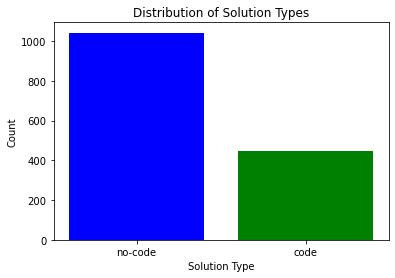

In [20]:
solution_type_counts = final_df['Solution_Type'].value_counts()

# Plot a bar chart
plt.bar(solution_type_counts.index, solution_type_counts.values, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Solution Type')
plt.ylabel('Count')
plt.title('Distribution of Solution Types')

# Show the plot
plt.show()

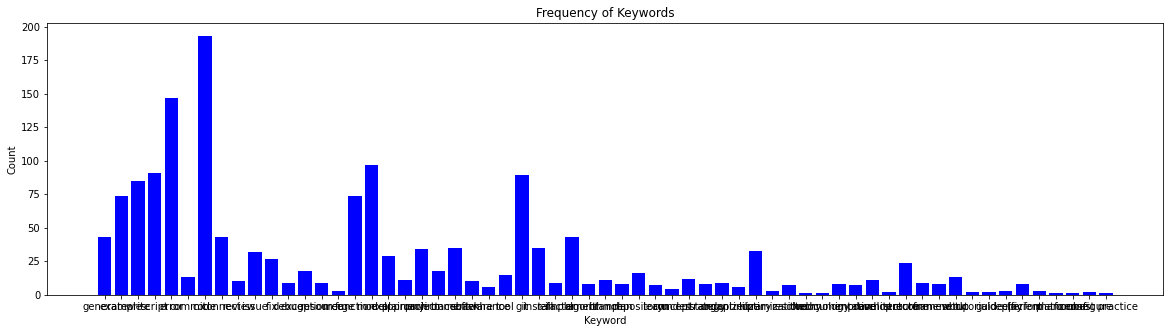

In [28]:
from collections import Counter
keyword_counts = Counter(all_keywords)

# Set the size of the figure
plt.figure(figsize=(20,5))  # Adjust the size as needed

# Plot a bar chart
plt.bar(keyword_counts.keys(), keyword_counts.values(), color='blue')

# Add labels and title
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Frequency of Keywords')

# Show the plot
plt.show()

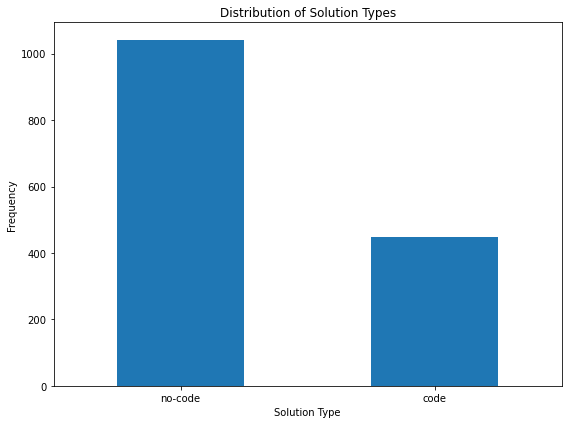

In [36]:
solution_type_counts = final_df['Solution_Type'].value_counts()
plt.figure(figsize=(8, 6))
solution_type_counts.plot(kind='bar')
plt.title('Distribution of Solution Types')
plt.xlabel('Solution Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the labels on the x-axis vertical
plt.tight_layout()
plt.show()

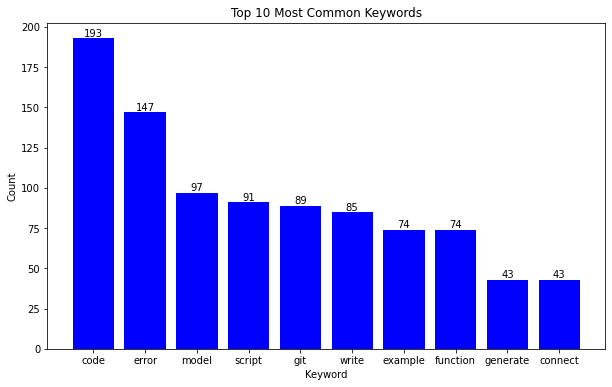

In [31]:
keyword_counts = Counter(all_keywords)

# Get the top 10 keywords
top_keywords = dict(keyword_counts.most_common(10))

# Set the size of the figure
plt.figure(figsize=(10, 6))

bars = plt.bar(top_keywords.keys(), top_keywords.values(), color='blue')

# Plot a bar chart for the top 10 keywords
plt.bar(top_keywords.keys(), top_keywords.values(), color='blue')

# Add labels and title
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Top 10 Most Common Keywords')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()

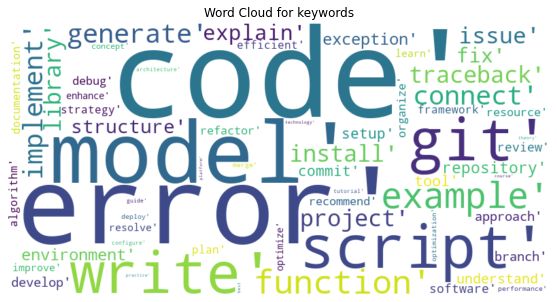

In [43]:
from wordcloud import WordCloud

prompt_text = ' '.join(final_df['Found_Keywords'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white", collocations=False).generate(prompt_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for keywords')
plt.show()

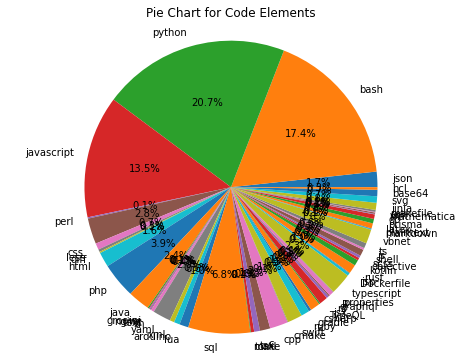

In [47]:
code_elements = [item for sublist in final_df['ListOfCode'] for item in sublist if isinstance(sublist, list)]
code_types = [item['Type'] for item in code_elements]

code_type_counts = Counter(code_types)

plt.figure(figsize=(8, 6))
plt.pie(code_type_counts.values(), labels=code_type_counts.keys(), autopct='%3.1f%%')
plt.title('Pie Chart for Code Elements')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

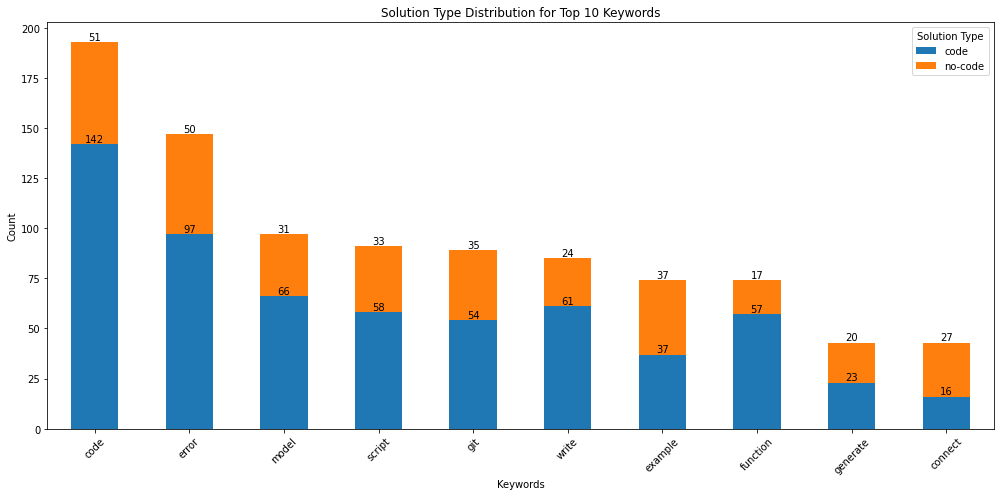

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Assuming df is your DataFrame containing the correct columns.
# Flatten the list of keywords and count occurrences
all_keywords = [keyword for keywords_list in final_df['Found_Keywords'] for keyword in keywords_list]
keyword_counts = Counter(all_keywords)

# Get the top 10 keywords
top_keywords = [keyword for keyword, count in keyword_counts.most_common(10)]

# Create a DataFrame to hold the solution type counts for each keyword
keyword_solution_df = pd.DataFrame(index=top_keywords, columns=final_df['Solution_Type'].unique())

# Initialize the DataFrame with zeros
keyword_solution_df.fillna(0, inplace=True)

# Iterate over the DataFrame and count the solution types for each keyword
for index, row in final_df.iterrows():
    for keyword in row['Found_Keywords']:
        if keyword in top_keywords:
            keyword_solution_df.at[keyword, row['Solution_Type']] += 1


# Plotting with numbers on top
ax = keyword_solution_df.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Solution Type Distribution for Top 10 Keywords')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Solution Type')

# Adding numbers on top of the bars
for bar in ax.patches:
    # The text annotation for each bar should be its height.
    height = bar.get_height()
    # If height is zero, we don't need to annotate anything.
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate position of text
            bar.get_y() + height,  # y-coordinate position of text
            f'{int(height)}',  # text to be displayed
            ha='center',  # horizontal alignment is center
            va='bottom'  # vertical alignment is bottom
        )

plt.tight_layout()  # Adjust the layout to make room for the x-axis labels
plt.show()


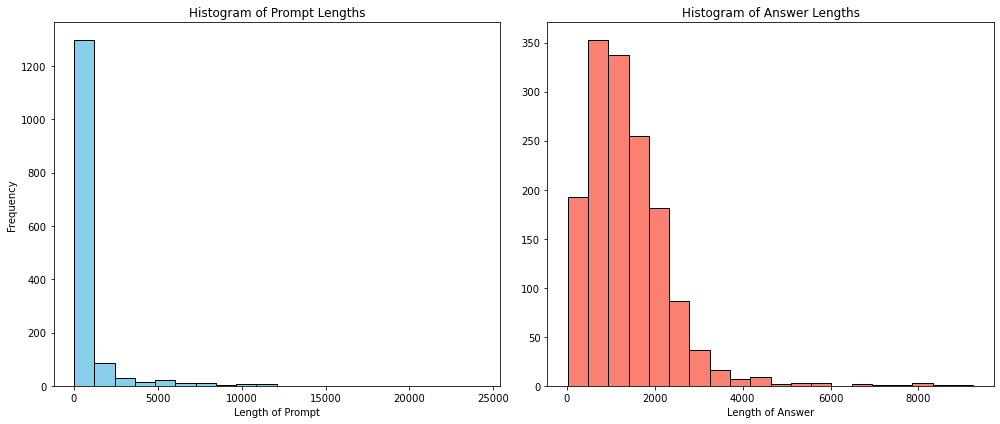

In [61]:
import matplotlib.pyplot as plt

# Calculate the length of prompts and answers
final_df['Prompt_Length'] = final_df['Prompt'].apply(len)
final_df['Answer_Length'] = final_df['Answer'].apply(len)

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(final_df['Prompt_Length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Prompt Lengths')
plt.xlabel('Length of Prompt')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(final_df['Answer_Length'], bins=20, color='salmon', edgecolor='black')
plt.title('Histogram of Answer Lengths')
plt.xlabel('Length of Answer')

plt.tight_layout()
plt.show()


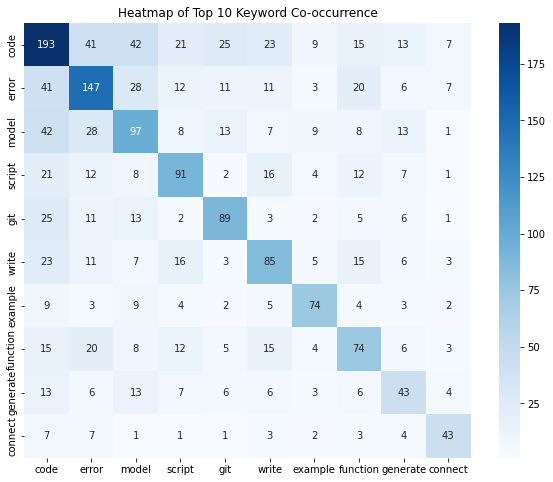

In [74]:
all_keywords = [keyword for keywords_list in final_df['Found_Keywords'] for keyword in keywords_list]
top_keywords = [keyword for keyword, count in Counter(all_keywords).most_common(10)]

# Initialize a co-occurrence matrix with zeros
co_occurrence_matrix = pd.DataFrame(0, index=top_keywords, columns=top_keywords)

# Populate the co-occurrence matrix
for keywords_list in final_df['Found_Keywords']:
    for keyword1 in keywords_list:
        for keyword2 in keywords_list:
            if keyword1 in top_keywords and keyword2 in top_keywords:
                co_occurrence_matrix.loc[keyword1, keyword2] += 1

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Heatmap of Top 10 Keyword Co-occurrence')
plt.show()

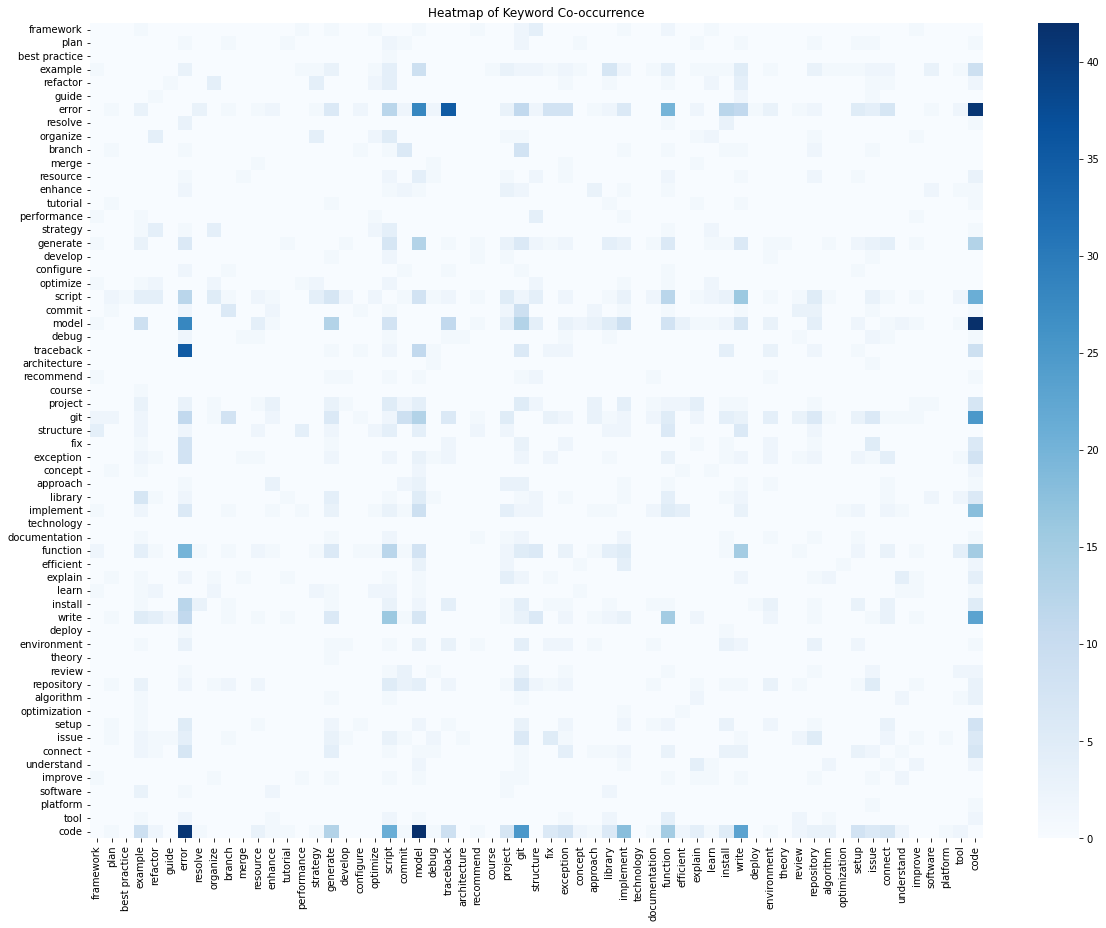

In [72]:
import seaborn as sns
import numpy as np

# Assuming df['Found_Keywords'] is a list of keywords
# Flatten the list of keywords and get unique keywords
unique_keywords = list(set(keyword for keywords_list in final_df['Found_Keywords'] for keyword in keywords_list))


# Create a co-occurrence matrix
co_occurrence_matrix = np.zeros((len(unique_keywords), len(unique_keywords)))

# Populate the co-occurrence matrix
for keywords_list in final_df['Found_Keywords']:
    indices = [unique_keywords.index(keyword) for keyword in keywords_list]
    for i in indices:
        for j in indices:
            if i != j:
                co_occurrence_matrix[i][j] += 1

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(co_occurrence_matrix, xticklabels=unique_keywords, yticklabels=unique_keywords, cmap='Blues')
plt.title('Heatmap of Keyword Co-occurrence')
plt.show()
